In [1]:
import os, sys
import json
import random
import pickle
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
# from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import Dataset_Reader

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
def save_model(model, filepath):
    """
    Save PyTorch model parameters to a file.

    Args:
    - model (torch.nn.Module): PyTorch model to save.
    - filepath (str): Filepath to save the model parameters.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model parameters saved to '{filepath}'")

def load_model(model, filepath):
    """
    Load PyTorch model parameters from a file.

    Args:
    - model (torch.nn.Module): PyTorch model to load parameters into.
    - filepath (str): Filepath to the saved model parameters.
    """
    model.load_state_dict(torch.load(filepath))
    print(f"Model parameters loaded from '{filepath}'")
    
def save_tensor(tensor, dir, filename):
    """
    Save PyTorch tensor to a file.

    Args:
    - tensor (torch.Tensor): PyTorch tensor to save.
    - dir (str): Directory to save the tensor.
    - filename (str): Filename to save the tensor.
    """
    
    if not os.path.exists(os.path.join(dir)):
        os.makedirs(os.path.join(dir))
        
    filepath = os.path.join(dir, filename)
    torch.save(tensor, filepath)
    print(f"Tensor saved to '{filepath}'")

def load_tensor(filepath):
    """
    Load PyTorch tensor from a file.

    Args:
    - filepath (str): Filepath to the saved tensor.

    Returns:
    - tensor (torch.Tensor): Loaded PyTorch tensor.
    """
    tensor = torch.load(filepath)
    print(f"Tensor loaded from '{filepath}'")
    return tensor

In [3]:
with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [4]:
TRAIN_data = Dataset_Reader(train_data)
TEST_data = Dataset_Reader(test_data)
print(len(TRAIN_data))
# TRAIN_data_batched = DataLoader(TRAIN_data, batch_size = 5, shuffle= True)

247


In [5]:
def max_length(documents, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    """
    Generate the maximum length of each sentence in each document. This is necessary to make sure there is a fixed sentence-length 
    for each document before we pass the sentence embeddings through the model.

    Returns: {document index: length of longest sentence}

    """
    max_l_dict = {}
    
    for sentence in documents.texts:
        size = []

        inputs = tokenizer(sentence[2], return_tensors="pt", truncation=True, padding=True, add_special_tokens= True)

        size.append(inputs['input_ids'].size(1))
        
        max_l_dict[sentence[0]] = max(size)
    
    dict_keys = list(max_l_dict.keys())
    reference_keys = list(range(len(documents)))  
    for key in reference_keys:
        if key not in dict_keys:
            max_l_dict[key] = 0
            
    return max_l_dict

In [7]:
def get_batched_data(data: Dataset, batch_size:int = 1) ->  Tuple[List,List,List]:
    doc_idx = []
    batched_texts = []
    batched_labels = []
    for start, stop in zip(range(0,len(data)-batch_size,batch_size), range(batch_size,len(data),batch_size)):
        idxs = []
        texts = []
        labels = []
        for idx in range(start,stop):
            idxs.append(idx) 
            [texts.append(text) for text in data[idx]['text']]
            [labels.append(label) for label in data[idx]['label']]
        
        doc_idx.append(idxs)
        batched_texts.append(texts)
        batched_labels.append(labels)
    return doc_idx, batched_texts, batched_labels

In [8]:
max_lens_train = max_length(TRAIN_data)

In [9]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [10]:
def label_encode(target_variables : list) -> LabelEncoder:
    """
    Encode target variables.
    
    Args:
    - target_variables (list or array-like): List of target variable strings.
    
    Returns:
    - lb (object): class object used to tranform and inverse transform.
    """
    le = LabelEncoder()
    le = le.fit(target_variables)
    
    return le

def get_model_data(data:torch.utils.data.Dataset, encoder: LabelEncoder,
                   tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                   model= BertModel.from_pretrained('bert-base-uncased'),
                   num_of_docs:int = None,
                   ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(data.labels)
    sent_emb = []
    max_sent_length = 128
    if num_of_docs is None:
        for idx, sentence in enumerate(data.texts):
            inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                padding='max_length', max_length = max_sent_length,
                                add_special_tokens= True)
            with torch.no_grad():
                output = model(**inputs)
            sent_emb.append(output.last_hidden_state[:,0,:])
    else:
        for idx, sentence in enumerate(data.texts):
            if sentence[0] < num_of_docs:
                inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                    padding='max_length', max_length = max_sent_length,
                                    add_special_tokens= True)
                with torch.no_grad():
                    output = model(**inputs)
                sent_emb.append(output.last_hidden_state[:,0,:]) 
        numerical_labels = numerical_labels[:len(sent_emb)]
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train

def get_model_data_batched(indexes:List, texts:List, labels:List, encoder:LabelEncoder,max_len_dict:Dict,
                           tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                           model= BertModel.from_pretrained('bert-base-uncased'),
                           ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(labels)
    sent_emb = []
    for idx, sentence in enumerate(texts):
        try:
            max_sent_length = max([max_len_dict[i] for i in indexes])
        except KeyError:
            continue
        inputs = tokenizer(sentence.lower(),  return_tensors="pt", truncation= True,
                            padding='max_length', max_length = max_sent_length,
                            add_special_tokens= True)
        with torch.no_grad():
            output = model(**inputs)
        sent_emb.append(output.last_hidden_state[:,0,:])
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train    
    

list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder = label_encode(list_of_targets)

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1),
        )
        
        self.apply(init_weights)
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [16]:
# TRAIN_emb, TRAIN_labels = get_model_data(data= TRAIN_data, encoder= label_encoder, num_of_docs= 10)
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

In [12]:
def train(x_train, y_train, model, optimizer, loss_fc, num_epochs):
    model.train()
    loss_list = []
    acc_list = []
    model.train()
    print(f'{"Starting Training":-^100}')
    for epoch in range(num_epochs+1):
        output = model(x_train)
        loss = loss_fc(output,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if epoch%50 == 0:
            acc = sum(output.argmax(dim=1) == y_train)/ output.size(0)
            acc_list.append(acc)
            print(f"Epoch: {epoch} \t Loss: {loss.item():.5f} \t Accuracy: {acc*100:.2f}%")
            
    return loss_list, acc_list
            
def test_accuracy(x_test, y_test, model):
    model.eval()
    output = model(x_test)
    acc = sum(output.argmax(dim=1) == y_test)/ output.size(0)
    print(f"Test Accuracy {acc*100:.2f}%")

In [18]:
# losses, accs = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,300)

In [19]:
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)
# test_accuracy(TEST_emb, TEST_labels, model)

In [20]:
model = BiLSTM(num_layers=1)
model_opt = torch.optim.RMSprop(model.parameters(), lr= 0.00008)
loss_function = nn.CrossEntropyLoss()

In [21]:
batch_loss, batch_acc = [], []
batch_counter = 0
random_doc_indexes = random.sample([i for i in range(len(batched_texts))],k=10)
print(random_doc_indexes)
for idx in random_doc_indexes:
    batch_counter += 1
    print(f"{f'BATCH NUMBER {batch_counter}':-^100}")
    TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx],batched_texts[idx],batched_labels[idx],label_encoder,max_lens_train)
    loss, acc = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,200)
    batch_loss.append(loss)
    batch_acc.append(acc)
    del TRAIN_emb, TRAIN_labels

[27, 52, 5, 55, 33, 51, 31, 60, 35, 9]
-------------------------------------------BATCH NUMBER 1-------------------------------------------
X_train size: torch.Size([274, 1, 768])	Y_train size: torch.Size([274])
-----------------------------------------Starting Training------------------------------------------
Epoch: 0 	 Loss: 2.56188 	 Accuracy: 3.28%
Epoch: 50 	 Loss: 2.02373 	 Accuracy: 67.52%
Epoch: 100 	 Loss: 2.00258 	 Accuracy: 68.61%
Epoch: 150 	 Loss: 1.91807 	 Accuracy: 77.74%
Epoch: 200 	 Loss: 1.89655 	 Accuracy: 79.56%
-------------------------------------------BATCH NUMBER 2-------------------------------------------
X_train size: torch.Size([225, 1, 768])	Y_train size: torch.Size([225])
-----------------------------------------Starting Training------------------------------------------
Epoch: 0 	 Loss: 2.28974 	 Accuracy: 43.56%
Epoch: 50 	 Loss: 2.01499 	 Accuracy: 67.56%
Epoch: 100 	 Loss: 1.94002 	 Accuracy: 75.11%
Epoch: 150 	 Loss: 1.93812 	 Accuracy: 75.11%
Epoch:

In [24]:
save_model(model, "../models/BiLSTM.pth")

Model parameters saved to '../models/BiLSTM.pth'


In [25]:
TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

X_train size: torch.Size([536, 1, 768])	Y_train size: torch.Size([536])
Test Accuracy 61.38%


In [107]:
test_accuracy(TEST_emb, TEST_labels, model)

Test Accuracy 47.57%


In [108]:
accs_plot = [acc[-1].item() for acc in batch_acc]
loss_plot = [np.mean(loss[-5:]) for loss in batch_loss]

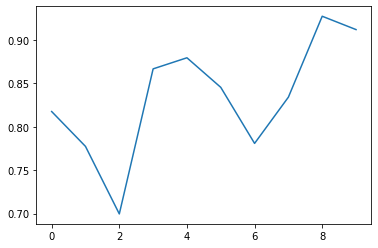

In [109]:
import seaborn as sns

sns.lineplot(x= range(len(accs_plot)), y= accs_plot);

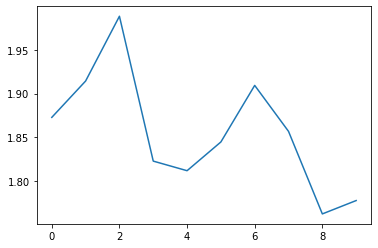

In [110]:
sns.lineplot(x= range(len(loss_plot)), y= loss_plot);

# -------------------------------------------------

# Saving document embeddings

In [20]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [21]:
for idx in range(len(doc_idxs)):
    TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_train)
    save_tensor(TRAIN_emb, '../train_document/doc_'+str(idx),"embedding")
    save_tensor(TRAIN_labels, '../train_document/doc_'+str(idx),"label")

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to '../train_document/doc_0/embedding'
Tensor saved to '../train_document/doc_0/label'
X_train size: torch.Size([72, 1, 768])	Y_train size: torch.Size([72])
Tensor saved to '../train_document/doc_1/embedding'
Tensor saved to '../train_document/doc_1/label'
X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])
Tensor saved to '../train_document/doc_2/embedding'
Tensor saved to '../train_document/doc_2/label'
X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])
Tensor saved to '../train_document/doc_3/embedding'
Tensor saved to '../train_document/doc_3/label'
X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])
Tensor saved to '../train_document/doc_4/embedding'
Tensor saved to '../train_document/doc_4/label'
X_train size: torch.Size([211, 1, 768])	Y_train size: torch.Size([211])
Tensor saved to '../train_document/doc_5/embedding'
Tensor saved to '../

In [ ]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TEST_data, batch_size= 1)
max_lens_test = max_length(TEST_data)

In [ ]:
for idx in range(len(doc_idxs)):
    TEST_emb, TEST_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_test)
    save_tensor(TEST_emb, '../test_document/doc_'+str(idx),"embedding")
    save_tensor(TEST_labels, '../test_document/doc_'+str(idx),"label")